In [99]:
import pandas as pd
import numpy as np
from scipy import stats

In [100]:
df_full = pd.read_csv('../data/transformed_data_raw.csv', index_col = 0)
df_full.head()

,Mobile Traffic,Time Spend On YouTube [min],Time Spend On TikTok [min],Time Spend On Instagram [min],Time Spend On Spotify [min],Size of home [m2],Occupation,Family Type,Family Interest,House Type,Number Of Residents,Average Age,Distance To Nearest Tower [m],Number Of Phones,Number Of Computers,Number Of Tvs,Number Of Pets,Customer Happiness
0,14.174436,10.374422,5.852715,48.865299,42.088255,157.863253,0.833333,0.75,0.833333,0.2,2,61,1395.406503,3,2,2,1,8.0
1,15.153522,13.119174,5.446513,8.536339,15.644445,137.409237,0.333333,0.50,0.500000,0.2,2,59,1680.966884,3,2,2,2,10.0
2,15.379938,11.266148,11.856355,8.321686,8.714800,175.179357,0.000000,0.25,0.000000,0.8,2,45,1358.849065,2,2,1,2,9.0
3,8.112265,9.749822,2.742474,7.807958,2.705742,146.414902,0.500000,0.50,0.333333,0.8,2,73,1778.094925,2,2,2,2,8.0
4,13.725759,11.792757,9.793580,10.063273,17.029632,152.456562,0.666667,0.00,0.333333,0.8,3,47,1218.390660,2,2,1,2,4.0


In [101]:
# # Hide last 200 observations for testing 
# df_unseen = df_raw[-200:]
# df = df_raw[:-200]


In [102]:

variables = list(df_full.columns)
target_var = "Mobile Traffic"
variables.remove(target_var)

# standardizing dataframe so coefficients are -1 and 1
df_full_z = df_full.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)

# Store mean and std to transform back 
mean_std={}
for var in df_full.columns:
    mean_std[var]=(df_full[var].mean(), df_full[var].std())

def reverse_zscore(pandas_series, mean, std):
    '''Mean and standard deviation should be of original variable before standardization'''
    yis=pandas_series*std+mean
    return yis

original_mean, original_std = mean_std[target_var]
original_var_series = reverse_zscore(df_full_z[target_var], original_mean, original_std)

Y_full_actual = df_full[target_var]
print("Prepared data")

Prepared data


In [103]:
df_z =  df_full_z[:-200]
Y_actual = Y_full_actual[:-200]

df_test_z = df_full_z[-200:]
Y_test_actual = Y_full_actual[-200:]


In [104]:
prediction_log = []
prediction_log_df = pd.DataFrame(columns = [
    "Time",
    "Mean Absolute Error", 
    "Mean Percentage Error",
    "Weights"
])

In [105]:
def manual_predict(weights):
    # Manually calculate y = alpha * x + beta
    X = df_z.copy()
    Y = X.pop(target_var)
    for i in X.columns:
        alpha = weights[i]
        X[i] = df_z[i] * alpha 
    Y_pred = X.sum(axis=1)
    
    Y_pred_trans = reverse_zscore(Y_pred, original_mean, original_std)

    return Y_pred_trans

def verify():
    record_log = prediction_log_df.sort_values("Mean Absolute Error").iloc[0,:]
    w = record_log.pop("Weights")
    print(f"The record log:")
    print(record_log)
    print(f"with Weights: ")
    print(pd.Series(w))
    y_p = manual_predict(w)
    mae = calc_mae(Y_actual, y_p)
    print(f"The calculated MAE: {mae}")

def calc_mae(Y_a, Y_p):
    return sum(abs(Y_a - Y_p))/len(Y_a)

In [106]:
Y_test_actual

1000    15.108063
1001    17.235518
1002     8.996272
1003    16.634565
1004    11.441465
          ...    
1195    18.005335
1196     9.970365
1197    22.195701
1198    17.389020
1199    14.732912
Name: Mobile Traffic, Length: 200, dtype: float64

In [107]:
import statsmodels.api as sm


X = df_z.copy()
Y = X.pop(target_var)

results = sm.OLS(Y,X).fit()

Y_train_pred_trans = reverse_zscore(results.fittedvalues, original_mean, original_std)
print(np.mean(abs(Y_actual - Y_train_pred_trans)))

results.summary()  


0.7872983485630275


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         Mobile Traffic   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              640.7
Date:                Tue, 17 Sep 2024   Prob (F-statistic):                        0.00
Time:                        08:47:55   Log-Likelihood:                         -184.82
No. Observations:                1000   AIC:                                      403.6
Df Residuals:                     983   BIC:                                      487.1
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Time Spend On YouTube [min]       0.1053      0.011      9.295      0.000       0.083       0.128
Time Spend On TikTok [min]        0.0984      0.011      9.099      0.000       0.077       0.120
Time Spend On Instagram [min]     0.0696      0.010      7.092      0.000       0.050       0.089
Time Spend On Spotify [min]       0.0245      0.009      2.692      0.007       0.007       0.042
Size of home [m2]                 0.1124      0.011     10.590      0.000       0.092       0.133
Occupation                       -0.0419      0.010     -4.264      0.000      -0.061      -0.023
Family Type                       0.0365      0.010      3.732      0.000       0.017       0.056
Family Interest                   0.0577      0.010      5.691      0.000       0.038       0.078
House Type                       -0.0006      0.009     -0.064      0.949      -0.019       0.018
Number Of Residents               0.2903      0.014     20.121      0.000       0.262       0.319
Average Age                      -0.5206      0.014    -36.515      0.000      -0.549      -0.493
Distance To Nearest Tower [m]     0.0384      0.013      2.851      0.004       0.012       0.065
Number Of Phones                  0.1680      0.013     13.133      0.000       0.143       0.193
Number Of Computers               0.1144      0.011     10.236      0.000       0.093       0.136
Number Of Tvs                     0.1053      0.010     10.638      0.000       0.086       0.125
Number Of Pets                   -0.1786      0.010    -17.836      0.000      -0.198      -0.159
Customer Happiness                0.3165      0.011     29.234      0.000       0.295       0.338
==============================================================================
Omnibus:                        2.599   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                2.661
Skew:                          -0.120   Prob(JB):                        0.264
Kurtosis:                       2.924   Cond. No.                         3.97
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
X_test = df_test_z.copy()
Y_test = X_test.pop(target_var)
Y_test_pred = results.predict(X_test)


0.7897401037853251


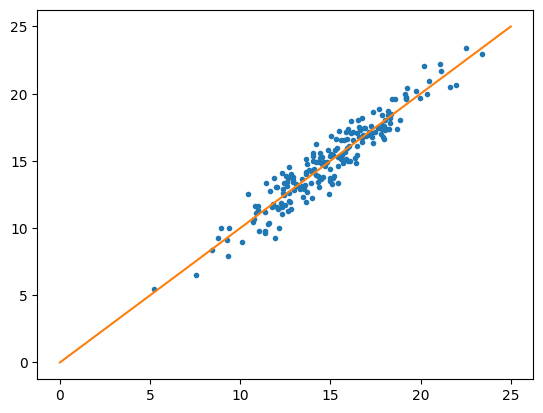

In [109]:

from matplotlib.pylab import plot
Y_test_pred_trans = reverse_zscore(Y_test_pred, original_mean, original_std)

print(np.mean(abs(Y_test_actual - Y_test_pred_trans)))

plot(Y_test_pred_trans,Y_test_actual,'.')
plot(np.linspace(0,25,10),np.linspace(0,25,10))